In [19]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,RocCurveDisplay,PrecisionRecallDisplay,ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV


In [20]:
data = pd.read_csv("anemia.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1421 entries, 0 to 1420
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Gender      1421 non-null   int64  
 1   Hemoglobin  1421 non-null   float64
 2   MCH         1421 non-null   float64
 3   MCHC        1421 non-null   float64
 4   MCV         1421 non-null   float64
 5   Result      1421 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 66.7 KB


In [21]:
data.describe()

,Gender,Hemoglobin,MCH,MCHC,MCV,Result
count,1421.000000,1421.000000,1421.000000,1421.000000,1421.000000,1421.000000
mean,0.520760,13.412738,22.905630,30.251232,85.523786,0.436312
std,0.499745,1.974546,3.969375,1.400898,9.636701,0.496102
min,0.000000,6.600000,16.000000,27.800000,69.400000,0.000000
25%,0.000000,11.700000,19.400000,29.000000,77.300000,0.000000
50%,1.000000,13.200000,22.700000,30.400000,85.300000,0.000000
75%,1.000000,15.000000,26.200000,31.400000,94.200000,1.000000
max,1.000000,16.900000,30.000000,32.500000,101.600000,1.000000


In [22]:
data = data.drop_duplicates()

In [23]:
class_distribution = data['Result'].value_counts(normalize=True)
print("Class Distribution:")
print(class_distribution)


Class Distribution:
Result
0    0.537453
1    0.462547
Name: proportion, dtype: float64


In [24]:
data["Gender"].value_counts()

Gender
1    279
0    255
Name: count, dtype: int64

In [25]:
data.isnull().sum()

Gender        0
Hemoglobin    0
MCH           0
MCHC          0
MCV           0
Result        0
dtype: int64

In [26]:
y = data["Result"]
x = data.drop(["Result","MCH","MCHC"],axis=1)
# x_dropped = data.drop(["MCH","MCHC"])

In [27]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,random_state=42)

In [28]:
# scaler = StandardScaler()

# X_train = scaler.fit_transform(xtrain)

# X_test = scaler.transform(xtest)

X_train = xtrain


In [29]:
X_test = xtest

In [30]:
X_train

,Gender,Hemoglobin,MCV
906,0,11.7,71.6
716,1,15.2,90.2
943,1,12.1,86.9
930,1,11.6,96.7
729,1,14.0,71.1
...,...,...,...
71,1,11.2,93.9
106,0,14.8,91.1
474,1,10.6,83.7
852,1,10.8,99.6


In [31]:
X_test

,Gender,Hemoglobin,MCV
222,0,11.1,73.3
131,1,13.9,98.5
149,1,16.4,77.4
290,0,10.5,83.2
84,1,12.8,100.9
...,...,...,...
738,1,13.2,70.4
177,0,11.5,100.8
220,1,11.4,70.0
1396,1,13.0,82.8


In [32]:
ytrain

906    1
716    0
943    1
930    1
729    0
      ..
71     1
106    0
474    1
852    1
102    1
Name: Result, Length: 427, dtype: int64

In [33]:
ytest

222     1
131     0
149     0
290     1
84      1
       ..
738     1
177     1
220     1
1396    1
800     0
Name: Result, Length: 107, dtype: int64

In [34]:
# Models to be evaluated
models = [
    ('RandomForest', RandomForestClassifier()),
    ('GradientBoosting', GradientBoostingClassifier()),
    ('SVM', SVC()),
    ("Logistic Regression",LogisticRegression(class_weight='balanced'))
]


In [35]:

# Pipeline for preprocessing and model training
results = {}
roc_auc_scores = {}
for name, model in models:
    pipe = Pipeline(steps=[('classifier', model)])
    # Define hyperparameters grid for GridSearchCV
    param_grid = {}
    if name == 'RandomForest':
        param_grid = {
            'classifier__n_estimators': [5,10,20,50, 100, 200],
            'classifier__max_depth': [None, 5, 10,20,30],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__class_weight': ['balanced']
        }
    elif name == 'GradientBoosting':
        param_grid = {
            'classifier__n_estimators': [5,10,20,50, 100, 200],
            'classifier__learning_rate': [0.1, 0.01,0.001],
            'classifier__max_depth': [3, 5, 7],
        }
    elif name == 'SVM':
        param_grid = {
            'classifier__C': [0.1, 1, 10],
            'classifier__kernel': ['linear', 'rbf'],
            'classifier__class_weight': ['balanced']
        }
    
    
    # Perform GridSearchCV
    grid_search = GridSearchCV(pipe, param_grid, cv=5)
    grid_search.fit(X_train, ytrain)
    
    # Save results
    results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        # 'test_accuracy': accuracy_score(ytest, grid_search.predict(X_test))
    }



In [36]:

# Print results
for name, result in results.items():
    print(f"{name}:")
    print("  Best Parameters:", result['best_params'])
    print("  Best CV Score:", result['best_score'])
    # print("  Test Accuracy:", result['test_accuracy'])

RandomForest:
  Best Parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 5}
  Best CV Score: 0.9976744186046511
GradientBoosting:
  Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 5}
  Best CV Score: 0.9953488372093023
SVM:
  Best Parameters: {'classifier__C': 10, 'classifier__class_weight': 'balanced', 'classifier__kernel': 'linear'}
  Best CV Score: 0.9859644322845418
Logistic Regression:
  Best Parameters: {}
  Best CV Score: 0.9789329685362518


In [37]:
rf = RandomForestClassifier(n_estimators=5)
rf.fit(X_train,ytrain)
rf_y_preds = rf.predict(X_test)
print(accuracy_score(ytest,rf_y_preds))

1.0


In [38]:
lr = LogisticRegression()
lr.fit(X_train,ytrain)
lr_y_preds = rf.predict(X_test)
print(accuracy_score(ytest,lr_y_preds))

1.0


In [39]:
svm = SVC(C= 10,kernel= 'linear')
svm.fit(X_train,ytrain)
svm_y_preds = rf.predict(X_test)
print(accuracy_score(ytest,svm_y_preds))

1.0


In [40]:
gb = GradientBoostingClassifier(n_estimators=50)
gb.fit(X_train,ytrain)
gb_y_preds = rf.predict(X_test)
print(accuracy_score(ytest,gb_y_preds))

1.0


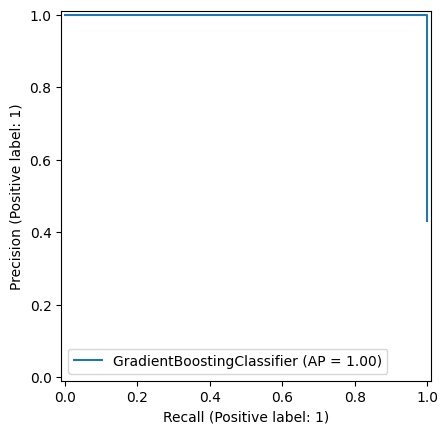

In [41]:
PrecisionRecallDisplay.from_estimator(gb,X_test,ytest)

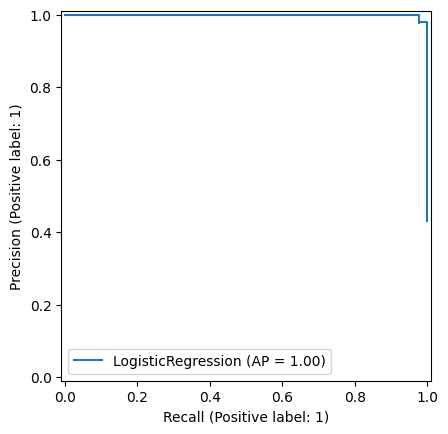

In [42]:
PrecisionRecallDisplay.from_estimator(lr,X_test,ytest)

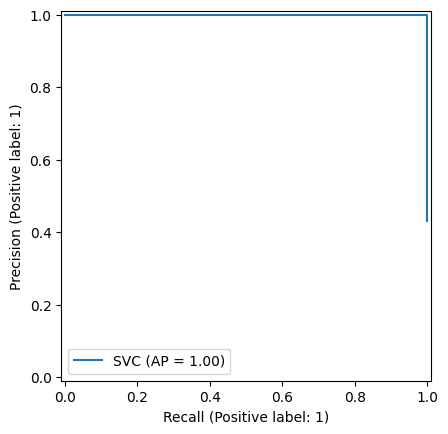

In [43]:
PrecisionRecallDisplay.from_estimator(svm,X_test,ytest)

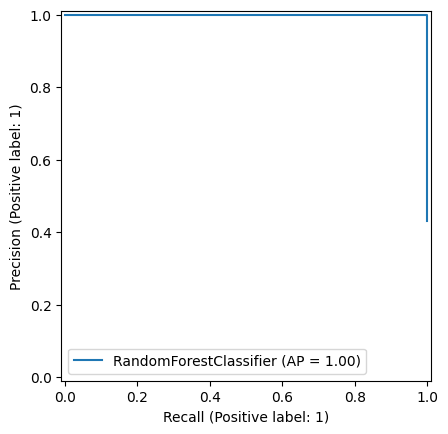

In [44]:
PrecisionRecallDisplay.from_estimator(rf,X_test,ytest)

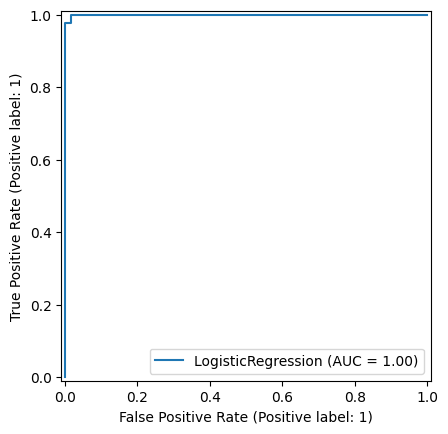

In [45]:
RocCurveDisplay.from_estimator(lr,xtest,ytest)

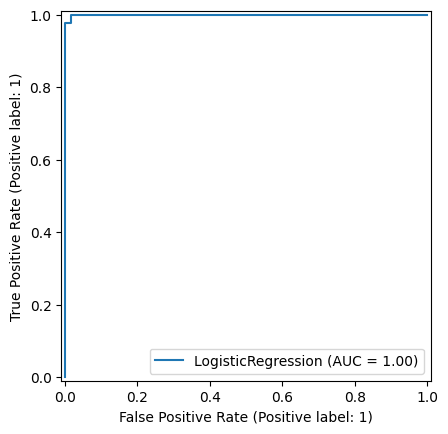

In [46]:
RocCurveDisplay.from_estimator(lr,X_test,ytest)

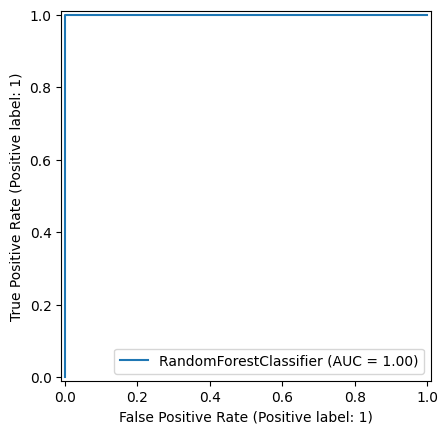

In [47]:
RocCurveDisplay.from_estimator(rf,X_test,ytest)

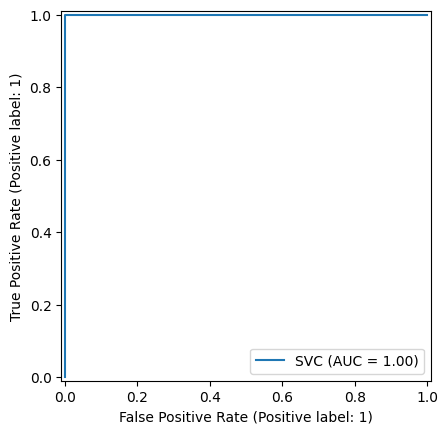

In [48]:
RocCurveDisplay.from_estimator(svm,X_test,ytest)

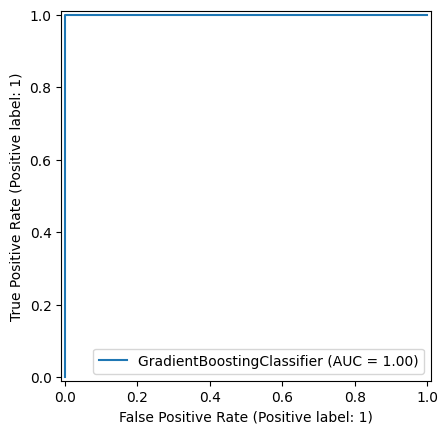

In [49]:
RocCurveDisplay.from_estimator(gb,X_test,ytest)

In [50]:
import joblib

joblib.dump(svm,"models/svm.pkl")

['models/svm.pkl']

In [51]:
data.shape

(534, 6)

In [52]:
X_train.shape

(427, 3)